<h1 style="text-align: center; font-weight: bold; font-size: 36px; ">Bone Fracture Classification Using Multiple CNN Architecture</h1>

#  Overview  

<p style="font-size: 16px;">This notebook focuses on classifying bone fractures by leveraging advanced Convolutional Neural Network (CNN) architectures such as ResNet50, InceptionV3, and MobileNetV2. By utilizing a medical imaging dataset, this project aims to develop robust deep learning models capable of accurately identifying fractures from X-ray images. Through meticulous data preprocessing, augmentation, and fine-tuning of pre-trained models, this analysis seeks to enhance model performance and generalization. Additionally, the comparative evaluation of multiple architectures provides actionable insights into the strengths of each approach, aiding in the selection of optimal models for medical diagnostics.</p>


# Table of Contents
- [Data Loading](#Data-Loading)
- [Data Prepartion](#Data-Preparation)
- [Data Visualization](#Data-Visualization)
- [Data Preprocessing](#Data-Preprocessing)
- [Model Building & Prediction](#Model-Building-&-Prediction)
  - [CNN Architecture](#CNN-Architecture)  
  - [CNN ResNet50 Architecture](#CNN-ResNet50-Architecture)  
  - [CNN InceptionV3 Architecture](#CNN-InceptionV3-Architecture)  
  - [CNN MobileNetV2 Architecture](#CNN-MobileNetV2-Architecture)  
- [Conclusion](#Conclusion)

## Objectives  
<p style="font-size: 16px;">
- Analyze relationships between bone fracture types, X-ray images, and the performance of different CNN architectures like ResNet50, InceptionV3, and MobileNetV2. <br>
- Perform data augmentation and preprocessing to improve model robustness and handle variations in image quality. <br>
- Evaluate the performance of different CNN architectures and select the most accurate model for bone fracture classification. <br>
- Build a model capable of accurately classifying bone fractures, helping in faster and more reliable medical diagnosis.
</p>

## Data Loading

In [ ]:
train_df=pd.read_csv('/kaggle/input/bone-fracture/dataset/train')
test_df=pd.read_csv('/kaggle/input/bone-fracture/dataset/test')
valid_df=pd.read_csv('/kaggle/input/bone-fracture/dataset/val')

## Data Preparation

In [74]:
# Improting Necessory Libraries

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, Dropout

import warnings
warnings.filterwarnings('ignore')

In [12]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [13]:
print(f'Train Data Shape: {train_df.shape}')
print(f'Test Data Shape: {test_df.shape}')
print(f'Valid Data Shape: {valid_df.shape}')

Train Data Shape: (4097, 2)
Test Data Shape: (399, 2)
Valid Data Shape: (404, 2)


In [15]:
train_df.sample(5)

image          label
117   /content/dataset/train/not fractured/24-rotate...  not fractured
1983  /content/dataset/train/not fractured/12-rotate...  not fractured
3539  /content/dataset/train/fractured/4-rotated1-ro...      fractured
2785  /content/dataset/train/fractured/79-rotated2-r...      fractured
1     /content/dataset/train/not fractured/60-rotate...  not fractured

## Data Visualization

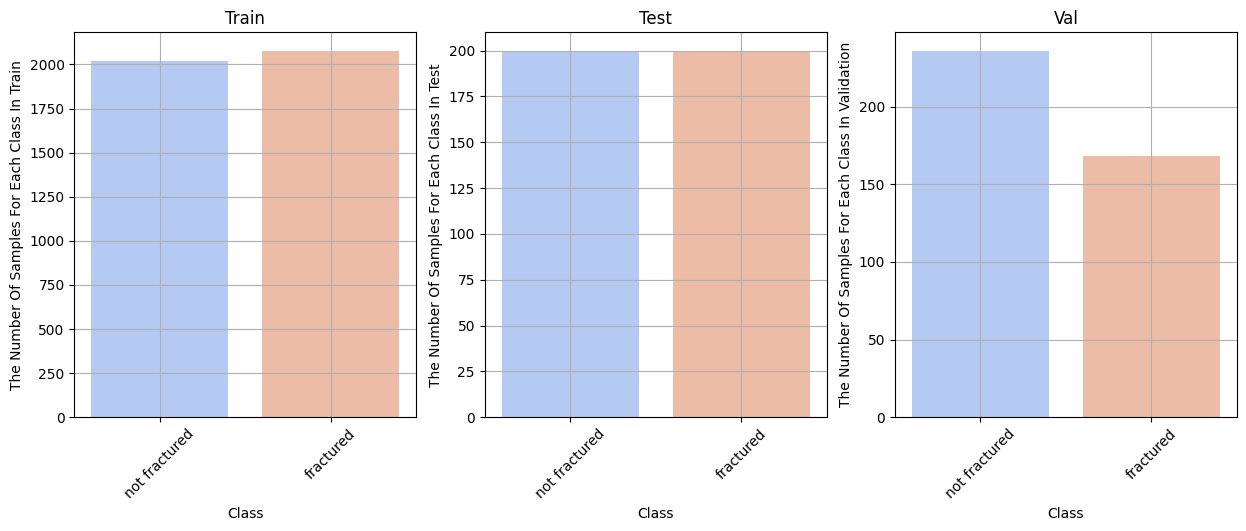

In [30]:
# Checking if the data is imbalance or not

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
ax = sns.countplot(x=train_df.label, palette='coolwarm')
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(1,3,2)
ax = sns.countplot(x=test_df.label, palette='coolwarm')
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)

ax = sns.countplot(x=valid_df.label, palette='coolwarm')
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Validation")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

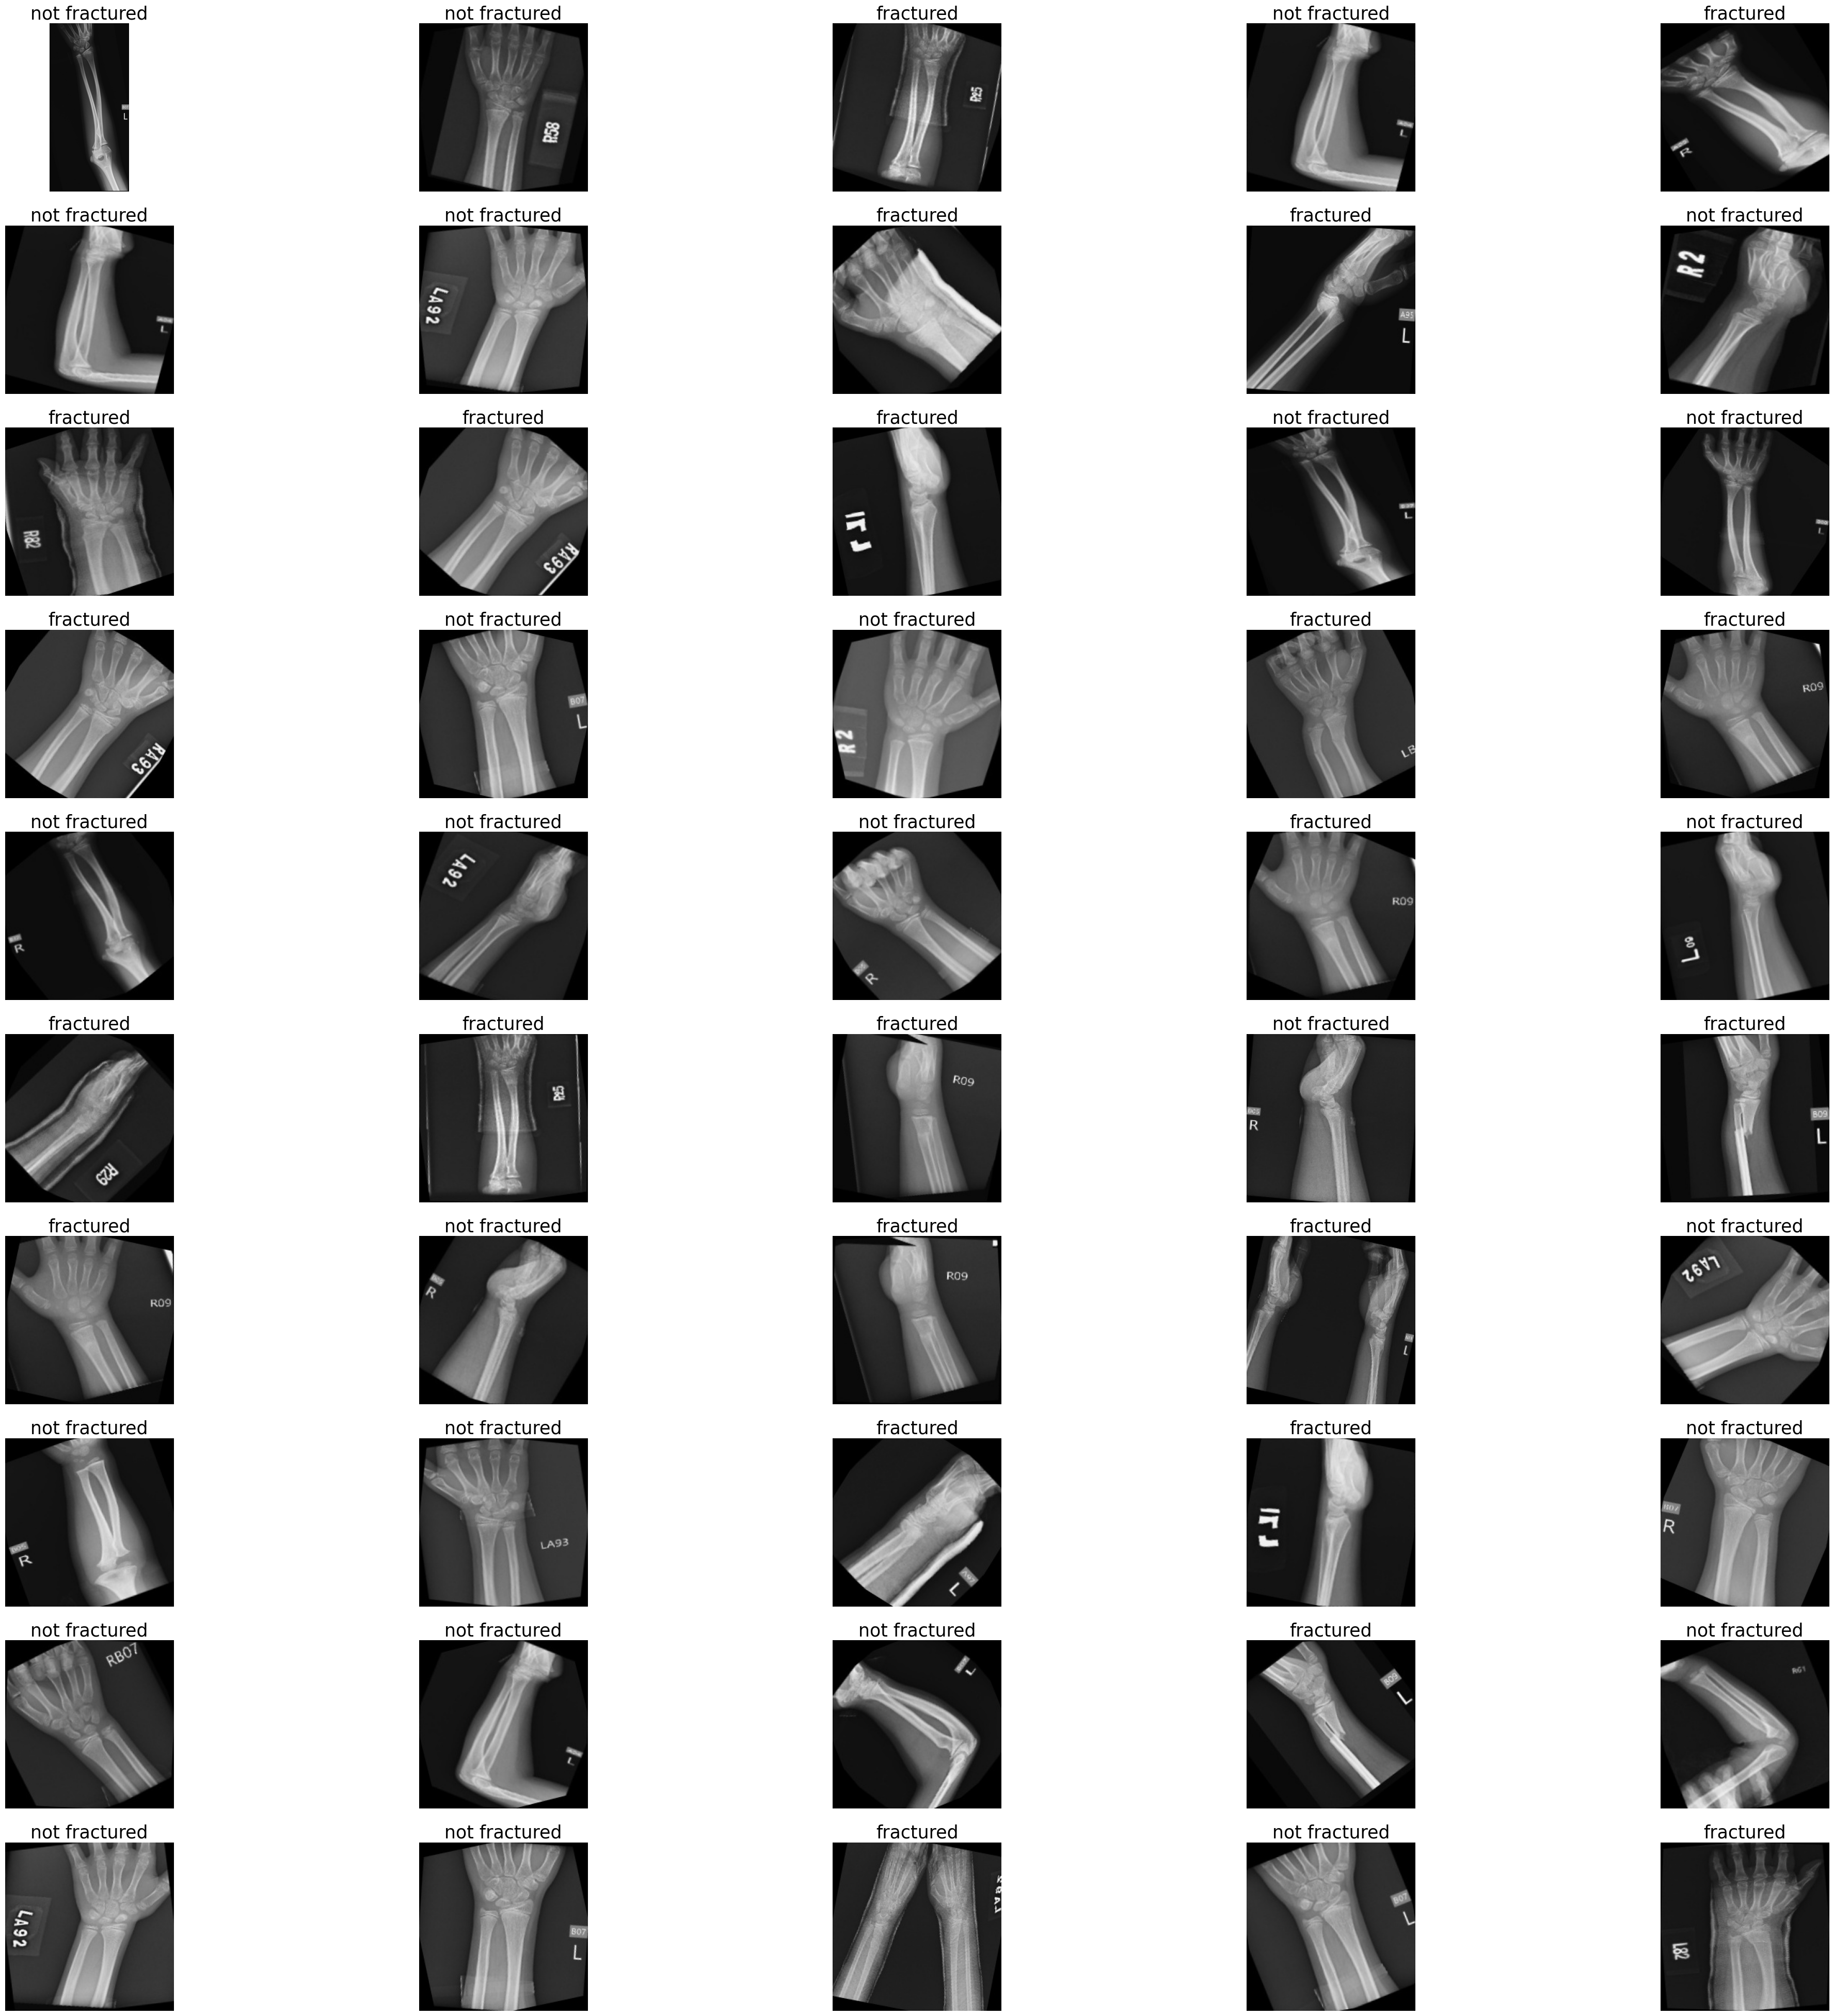

In [36]:
# Visualizing the dataset

plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train_df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train_df.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train_df.label[i],fontsize=25)

## Data Preprocessing

In [38]:
# Data Augmentation

image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


## Model Building & Prediction

### CNN Architecture

In [64]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [65]:
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,593 (84.99 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [67]:
history=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    )

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.6719 - loss: 5.8047 - val_accuracy: 0.5842 - val_loss: 15.8838
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.8689 - loss: 1.0884 - val_accuracy: 0.5891 - val_loss: 11.7628
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9097 - loss: 0.4933 - val_accuracy: 0.6386 - val_loss: 7.9170
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9433 - loss: 0.3332 - val_accuracy: 0.7475 - val_loss: 2.2858
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9498 - loss: 0.1849 - val_accuracy: 0.9876 - val_loss: 0.0356
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9576 - loss: 0.2019 - val_accuracy: 0.9901 - val_loss: 0.0183
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9662 - loss: 0.1778 - val_accuracy: 0.9332 - val_loss: 0.4735
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9678 - loss: 0.1634 -

In [68]:
history_df=pd.DataFrame(history.history)
history_df

accuracy      loss  val_accuracy   val_loss
0  0.749817  3.789516      0.584158  15.883822
1  0.883085  0.865207      0.589109  11.762840
2  0.915548  0.487335      0.638614   7.917047
3  0.932145  0.417382      0.747525   2.285780
4  0.951672  0.184804      0.987624   0.035584
5  0.960215  0.190972      0.990099   0.018293
6  0.968025  0.175666      0.933168   0.473463
7  0.968269  0.169142      0.990099   0.025861
8  0.976080  0.108340      0.987624   0.037460
9  0.980474  0.113291      1.000000   0.000208

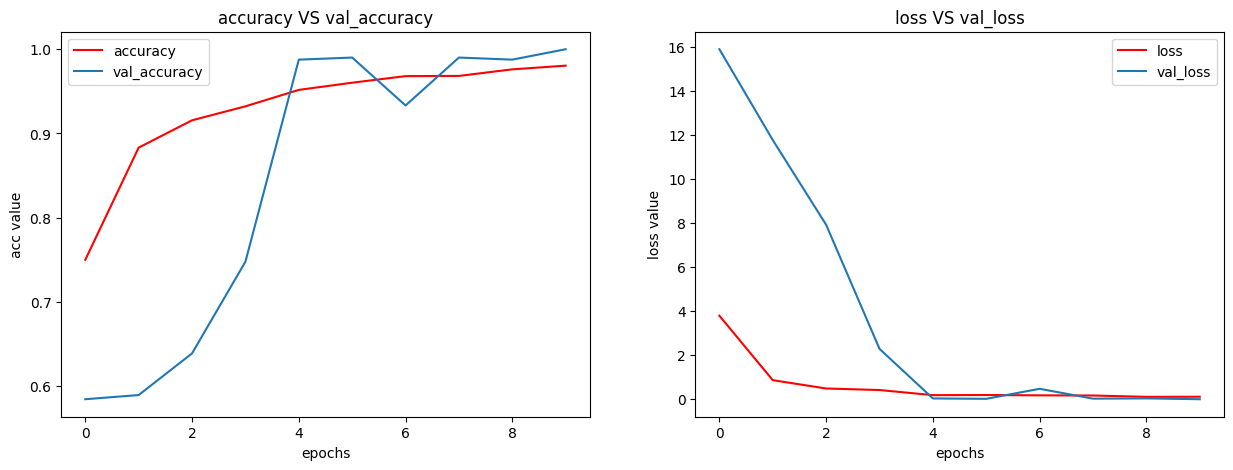

In [69]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

In [70]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


Actual  Prediction
0         1           1
1         1           1
2         1           1
3         1           1
4         1           1
..      ...         ...
394       0           0
395       0           0
396       0           0
397       0           0
398       0           0

[399 rows x 2 columns]

array([[199,   0],
       [  0, 200]])

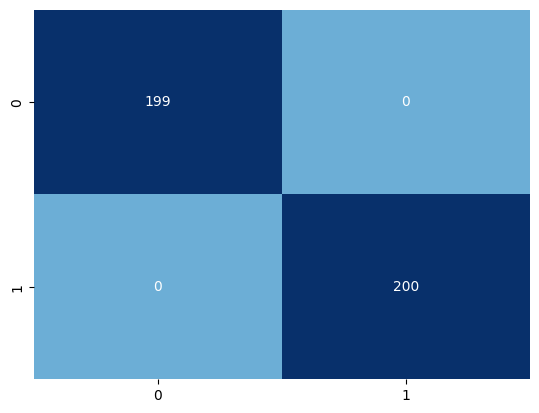

In [71]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

### CNN ResNet50 Architecture

In [83]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [84]:
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [85]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,311,105 (188.11 MB)

 Trainable params: 25,723,393 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [87]:
history=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    )

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 229ms/step - accuracy: 0.5052 - loss: 0.9225 - val_accuracy: 0.4158 - val_loss: 0.7072
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5055 - loss: 0.6931 - val_accuracy: 0.4158 - val_loss: 0.6855
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.5255 - loss: 0.6816 - val_accuracy: 0.4455 - val_loss: 0.6763
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.5354 - loss: 0.6792 - val_accuracy: 0.7970 - val_loss: 0.6669
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.5638 - loss: 0.6681 - val_accuracy: 0.6337 - val_loss: 0.6490
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.5461 - loss: 0.6693 - val_accuracy: 0.7995 - val_loss: 0.6486
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.5797 - loss: 0.6594 - val_accuracy: 0.6856 - val_loss: 0.6308
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.5976 - loss: 0

In [88]:
history_df=pd.DataFrame(history.history)
history_df

accuracy      loss  val_accuracy  val_loss
0  0.506956  0.789582      0.415842  0.707202
1  0.503783  0.688755      0.415842  0.685485
2  0.517696  0.679748      0.445545  0.676320
3  0.538931  0.677516      0.797030  0.666936
4  0.576031  0.665927      0.633663  0.649011
5  0.549671  0.673051      0.799505  0.648583
6  0.578472  0.657743      0.685644  0.630782
7  0.594581  0.652253      0.759901  0.650918
8  0.605077  0.643691      0.717822  0.615646
9  0.577740  0.663557      0.816832  0.623855

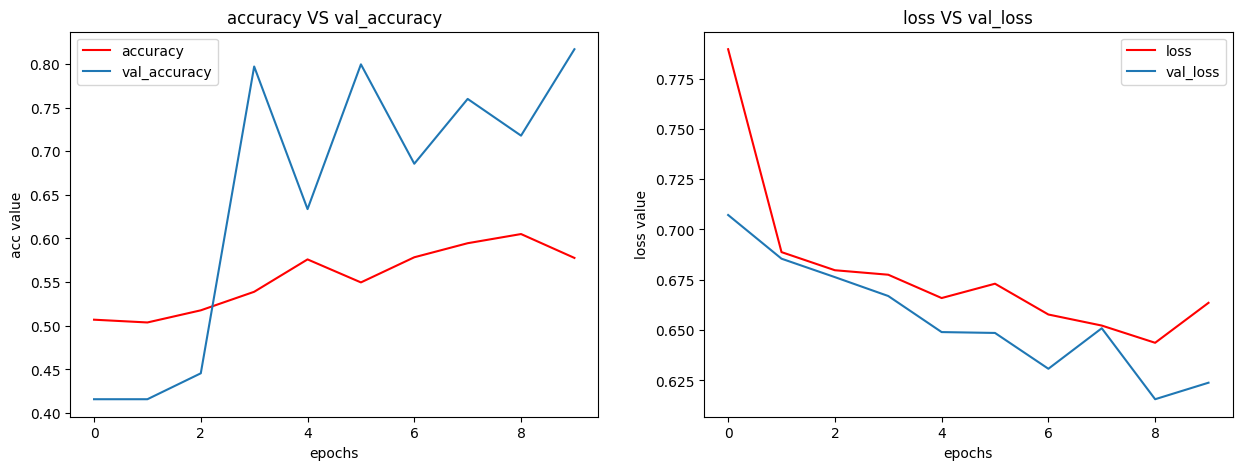

In [89]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

In [90]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 547ms/step


Actual  Prediction
0         1           1
1         1           1
2         1           0
3         1           1
4         1           1
..      ...         ...
394       0           0
395       0           0
396       0           0
397       0           0
398       0           1

[399 rows x 2 columns]

array([[133,  66],
       [ 27, 173]])

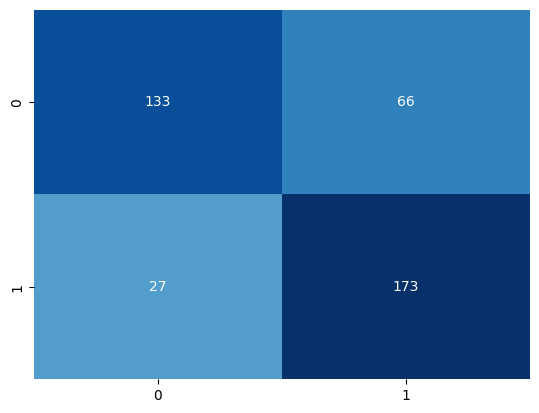

In [91]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

### CNN InceptionV3 Architecture

In [92]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [93]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [94]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [95]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [96]:
history=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    )

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 46s 213ms/step - accuracy: 0.6570 - loss: 0.6262 - val_accuracy: 0.9134 - val_loss: 0.3193
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8378 - loss: 0.3692 - val_accuracy: 0.9505 - val_loss: 0.2131
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9022 - loss: 0.2592 - val_accuracy: 0.9629 - val_loss: 0.1749
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.9310 - loss: 0.2013 - val_accuracy: 0.9851 - val_loss: 0.1160
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9603 - loss: 0.1506 - val_accuracy: 0.9926 - val_loss: 0.0890
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9672 - loss: 0.1228 - val_accuracy: 0.9975 - val_loss: 0.0717
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9741 - loss: 0.1037 - val_accuracy: 0.9926 - val_loss: 0.0577
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9840 - loss: 0.0793 -

In [97]:
history_df=pd.DataFrame(history.history)
history_df

accuracy      loss  val_accuracy  val_loss
0  0.728338  0.529836      0.913366  0.319344
1  0.862338  0.334431      0.950495  0.213074
2  0.912619  0.238007      0.962871  0.174924
3  0.936783  0.190454      0.985148  0.115966
4  0.960703  0.144021      0.992574  0.089049
5  0.971198  0.114625      0.997525  0.071668
6  0.978277  0.097186      0.992574  0.057733
7  0.985111  0.076536      0.995049  0.046214
8  0.987064  0.068867      0.997525  0.039433
9  0.989260  0.058096      0.992574  0.040687

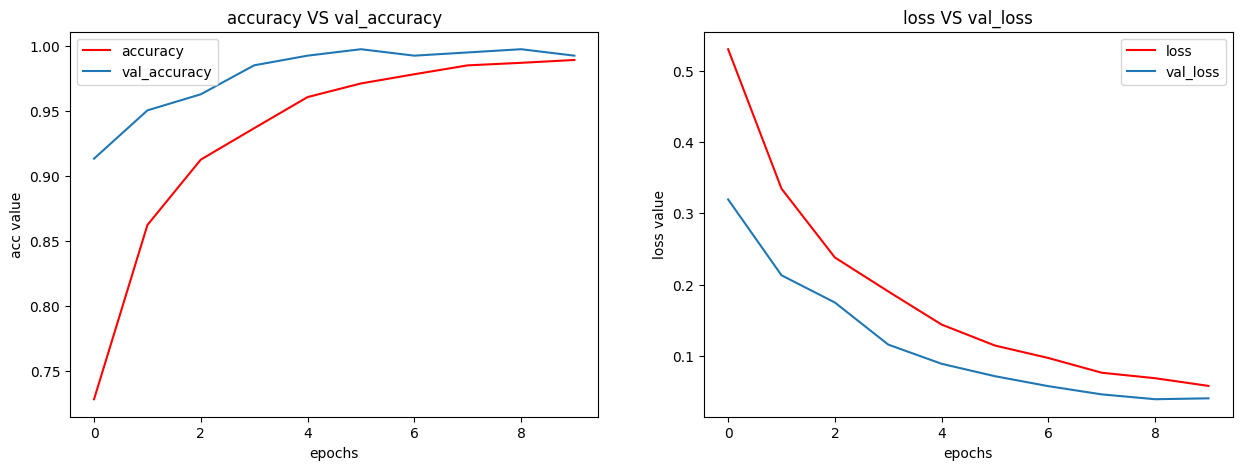

In [98]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

In [99]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 798ms/step


Actual  Prediction
0         1           1
1         1           1
2         1           1
3         1           1
4         1           1
..      ...         ...
394       0           0
395       0           0
396       0           0
397       0           0
398       0           0

[399 rows x 2 columns]

array([[192,   7],
       [  0, 200]])

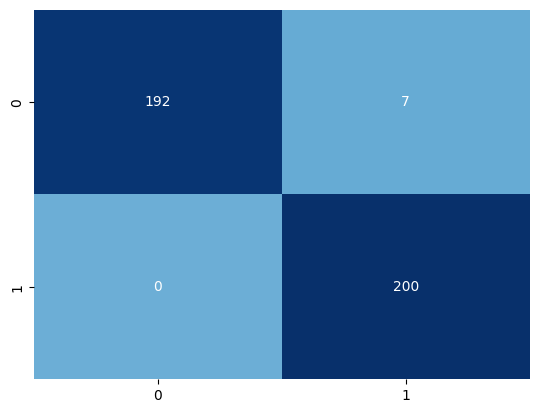

In [100]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

### CNN MobileNetV2 Architecture

In [101]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [102]:
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [103]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [105]:
history=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    )

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 187ms/step - accuracy: 0.6138 - loss: 0.6860 - val_accuracy: 0.8663 - val_loss: 0.3865
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.8049 - loss: 0.4307 - val_accuracy: 0.9134 - val_loss: 0.2997
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.8603 - loss: 0.3493 - val_accuracy: 0.9332 - val_loss: 0.2374
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9028 - loss: 0.2806 - val_accuracy: 0.9554 - val_loss: 0.1992
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9230 - loss: 0.2330 - val_accuracy: 0.9579 - val_loss: 0.1610
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9355 - loss: 0.2063 - val_accuracy: 0.9678 - val_loss: 0.1339
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9443 - loss: 0.1827 - val_accuracy: 0.9752 - val_loss: 0.1279
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9522 - loss: 0.1540 - 

In [106]:
history_df=pd.DataFrame(history.history)
history_df

accuracy      loss  val_accuracy  val_loss
0  0.681474  0.595827      0.866337  0.386543
1  0.817427  0.410053      0.913366  0.299690
2  0.867708  0.341793      0.933168  0.237368
3  0.900171  0.277293      0.955446  0.199176
4  0.922382  0.230195      0.957921  0.161037
5  0.939224  0.201615      0.967822  0.133940
6  0.948255  0.174514      0.975248  0.127867
7  0.955089  0.152804      0.982673  0.099651
8  0.964608  0.135488      0.982673  0.086479
9  0.972175  0.119151      0.990099  0.072371

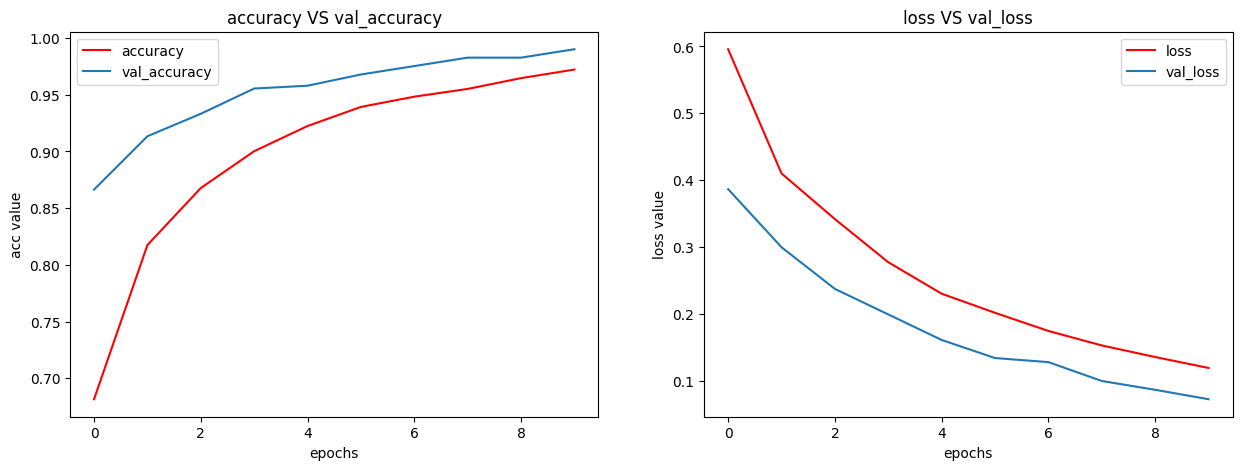

In [107]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

In [108]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step


Actual  Prediction
0         1           1
1         1           1
2         1           1
3         1           1
4         1           1
..      ...         ...
394       0           0
395       0           0
396       0           0
397       0           1
398       0           0

[399 rows x 2 columns]

array([[190,   9],
       [  1, 199]])

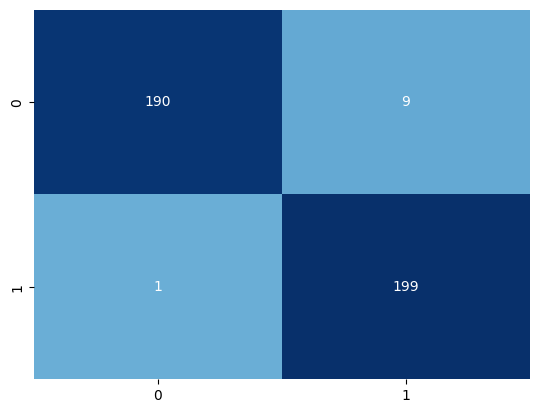

In [109]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

## Conclusion

In this notebook, we successfully built a model to classify bone fractures using multiple CNN architectures, including ResNet50, InceptionV3, and MobileNetV2. Through careful data preprocessing, augmentation, and model fine-tuning, our experiments demonstrated that MobileNetV2 and InceptionV3 achieved better classification performance, surpassing other architectures in terms of accuracy and generalization.

These models were able to effectively identify bone fractures, showcasing their potential for medical applications such as diagnostic tools for X-ray images. The improved performance of MobileNetV2 and InceptionV3 highlights their efficiency and suitability for medical image classification tasks, providing reliable results even with limited data or computational resources.